# Sun Glint Computation analog to 6SV

In [282]:
import numpy as np
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mi.set_variant("llvm_ad_rgb")

In [283]:
def cos(x):
    return np.cos(x)

def sin(x): 
    return np.sin(x)

def rnd(x, decimals=8):
    return round(x, decimals)

def friedman_sverdrup(chlorinity):
    return 0.00017492711 * (0.03 + 1.805 * chlorinity)

def fresnel(nr, ni, coschi, sinchi):
    a1 = np.abs(nr * nr - ni * ni - sinchi * sinchi)
    a2 = np.sqrt((nr * nr - ni * ni - sinchi * sinchi) ** 2 + 4 * nr * nr * ni * ni)
    u = np.sqrt(0.5 * np.abs(a1 + a2))
    v = np.sqrt(0.5 * np.abs(-a1 + a2))
    Rr2 = ((coschi - u) ** 2 + v * v) / ((coschi + u) ** 2 + v * v)
    b1 = (nr * nr - ni * ni) * coschi
    b2 = 2 * nr * ni * coschi
    Rl2 = ((b1 - u) ** 2 + (b2 + v) ** 2) / ((b1 + u) ** 2 + (b2 - v) ** 2)
    R1 = (Rr2 + Rl2) / 2.0
    return R1

def cox_munk(phw, zx, zy, wspd):
    sigmaC = 0.003 + 0.00192 * wspd
    sigmaU = 0.00316 * wspd
    C21 = 0.01 - 0.0086 * wspd
    C03 = 0.04 - 0.033 * wspd
    C40 = 0.40
    C22 = 0.12
    C04 = 0.23
    xe = (rnd(cos(phw)) * zx + rnd(sin(phw)) * zy) / np.sqrt(sigmaC)
    xn = (-rnd(sin(phw)) * zx + rnd(cos(phw)) * zy) / np.sqrt(sigmaU)
    xe2 = xe * xe
    xn2 = xn * xn
    coef = 1.0 - (C21 / 2.0) * (xe2 - 1.0) * xn - (C03 / 6.0) * (xn2 - 3) * xn
    coef = coef + (C40 / 24.0) * (xe2 * xe2 - 6.0 * xe2 + 3.0)
    coef = coef + (C04 / 24.0) * (xn2 * xn2 - 6.0 * xn2 + 3.0)
    coef = coef + (C22 / 4.0) * (xe2 - 1.0) * (xn2 - 1.0)
    prob = coef / 2.0 / np.pi / np.sqrt(sigmaU) / np.sqrt(sigmaC) * np.exp(-(xe2 + xn2) / 2.0)
    return prob

def sunglint(to, ti, po, pi, pu, wspd, nr, ni, chlor):
    phi = pi - po
    phw = pi - pu
    cs = rnd(cos(ti))
    cv = rnd(cos(np.pi / 2 - to))
    ss = rnd(sin(ti))
    sv = rnd(sin(np.pi / 2 - to))
    zx = -sv * rnd(sin(phi)) / (cs + cv)
    zy = (ss + sv * rnd(cos(phi))) / (cs + cv)

    # Tilt
    tan_tilt = np.sqrt(zx * zx + zy * zy)
    tilt = np.arctan(tan_tilt)

    # Cox Munk term
    specular_prob = cox_munk(phw, zx, zy, wspd)
    
    # Fresnel term
    cos2chi = cv * cs + sv * ss * cos(phi)
    
    if cos2chi > 1.0:
        cos2chi = 0.999999999
    elif cos2chi < -1.0:
        cos2chi = -0.999999999
    coschi = np.sqrt(0.5 * (1.0 + cos2chi))
    sinchi = np.sqrt(0.5 * (1.0 - cos2chi))
    if coschi > 1.0:
        coschi = 0.999999999
    elif coschi < -1.0:
        coschi = -0.999999999
    if sinchi > 1.0:
        sinchi = 0.999999999
    elif sinchi < -1.0:
        sinchi = -0.999999999

    nr_corr = nr + friedman_sverdrup(chlor)
    R = fresnel(nr_corr, ni, coschi, sinchi)
    reflectance = (np.pi * specular_prob * R) / (4.0 * cs * cv * cos(tilt) ** 4)

    # Reflectance of sun glint
    return specular_prob, R, tilt, cs, cv, reflectance

In [284]:
# Some parameters for the test case
#   Sun angle
azim_s = 0.0

#   Wind speed and direction
wind_speed = 10
azim_w = 0.0

#   Water properties (IOR and chlorinity)
n_real = 1.333
n_imag = 0.0
chlorinity = 19

#   Variable sensor position
res = 50
epsilon = 1.0 * np.pi / 180
azim_vs = np.linspace(0, 2 * np.pi, 2 * res)
zen_vs = np.linspace(0, np.deg2rad(89), res)
    

In [285]:
# Unit Test
spec, R, tilt, cs, cv, reflectance = sunglint(np.pi / 2, 0, np.pi, 0, 0, 10, n_real, n_imag, chlorinity)
print(f"Specular probability: {spec}")
print(f"Reflectance: {R}")
print(f"Tilt: {tilt}")
print(f"Sun cosine: {cs}")
print(f"View cosine: {cv}")
print(f"Reflectance: {reflectance}")    

Specular probability: 6.662446520240068
Reflectance: 0.021006250176069084
Tilt: 0.0
Sun cosine: 1.0
View cosine: 1.0
Reflectance: 0.10991884360452721


In [286]:
# Computation
results = {}
solar_zeniths = np.linspace(np.deg2rad(1), np.deg2rad(89), 89)

idx = 0
max_idx = len(solar_zeniths)
visuals = ["specular", "fresnel", "tilt", "cosine_solar", "cosine_view", "reflectance"]

for zen_s in solar_zeniths:
    speculars = np.zeros((res, 2 * res))
    fresnels = np.zeros((res, 2 * res))
    tilts = np.zeros((res, 2 * res))
    cosine_s = np.zeros((res, 2 * res))
    cosine_v = np.zeros((res, 2 * res))
    sunglint_reflectances = np.zeros((res, 2 * res))
    for i, zen_v in enumerate(zen_vs):
        for j, azim_v in enumerate(azim_vs):
            spec, R, tilt, cs, cv, reflectance = sunglint(zen_v, zen_s, azim_v, azim_s, azim_w,
                            wind_speed, n_real, n_imag, chlorinity)
            if np.abs(np.pi / 2 - zen_s) < 1e-6:
                speculars[i, j] = 0
                fresnels[i, j] = 0
                tilts[i, j] = 0
                cosine_s[i, j] = 0
                cosine_v[i, j] = 0            
                reflectance = 0
                sunglint_reflectances[i, j] = 0
                continue
            
            # Clamp the cosines to avoid numerical issues
            cs = np.clip(cs, 0, 1.0)
            cv = np.clip(cv, 0, 1.0)

            speculars[i, j] = spec
            fresnels[i, j] = R
            tilts[i, j] = tilt
            cosine_s[i, j] = cs
            cosine_v[i, j] = cv            
            reflectance = (np.pi * R * spec) / (4.0 * cs * np.cos(tilt) ** 4)

            sunglint_reflectances[i, j] = reflectance
    results[zen_s] = {
        visuals[0]: speculars,
        visuals[1]: fresnels,
        visuals[2]: tilts,
        visuals[3]: cosine_s,
        visuals[4]: cosine_v,
        visuals[5]: sunglint_reflectances
    }
    idx = idx + 1
    print(f"Progress: {idx}/{max_idx}")

/var/folders/2y/rhmx4lpx7yj6c8p50ldw1x_c0000gp/T/ipykernel_89228/3491533193.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  reflectance = (np.pi * specular_prob * R) / (4.0 * cs * cv * cos(tilt) ** 4)


Progress: 1/89
Progress: 2/89
Progress: 3/89
Progress: 4/89
Progress: 5/89
Progress: 6/89
Progress: 7/89
Progress: 8/89
Progress: 9/89
Progress: 10/89
Progress: 11/89
Progress: 12/89
Progress: 13/89
Progress: 14/89
Progress: 15/89
Progress: 16/89
Progress: 17/89
Progress: 18/89
Progress: 19/89
Progress: 20/89
Progress: 21/89
Progress: 22/89
Progress: 23/89
Progress: 24/89
Progress: 25/89
Progress: 26/89
Progress: 27/89
Progress: 28/89
Progress: 29/89
Progress: 30/89
Progress: 31/89
Progress: 32/89
Progress: 33/89
Progress: 34/89
Progress: 35/89
Progress: 36/89
Progress: 37/89
Progress: 38/89
Progress: 39/89
Progress: 40/89
Progress: 41/89
Progress: 42/89
Progress: 43/89
Progress: 44/89
Progress: 45/89
Progress: 46/89
Progress: 47/89
Progress: 48/89
Progress: 49/89
Progress: 50/89
Progress: 51/89
Progress: 52/89
Progress: 53/89
Progress: 54/89
Progress: 55/89
Progress: 56/89
Progress: 57/89
Progress: 58/89
Progress: 59/89
Progress: 60/89
Progress: 61/89
Progress: 62/89
Progress: 63/89
P

/var/folders/2y/rhmx4lpx7yj6c8p50ldw1x_c0000gp/T/ipykernel_89228/3491533193.py:81: RuntimeWarning: invalid value encountered in scalar divide
  reflectance = (np.pi * specular_prob * R) / (4.0 * cs * cv * cos(tilt) ** 4)


Progress: 74/89
Progress: 75/89
Progress: 76/89
Progress: 77/89
Progress: 78/89
Progress: 79/89
Progress: 80/89
Progress: 81/89
Progress: 82/89
Progress: 83/89
Progress: 84/89
Progress: 85/89
Progress: 86/89
Progress: 87/89
Progress: 88/89
Progress: 89/89


In [287]:
# Clear all files in cox_munk
import os

for file in os.listdir("glints"):
    os.remove(os.path.join("glints", file))

In [288]:
titles = {
    "specular": "Cox-Munk Specular Probability",
    "fresnel": "Fresnel Coefficient",
    "tilt": "Tilt Angle",
    "cosine_solar": "Cosine of Solar Angle",
    "cosine_view": "Cosine of View Angle",
    "reflectance": "Sunglint Reflectance"
}

idx = 0
for solar_zenith, glint_data in results.items():
    for title, data in glint_data.items():
        ax = plt.gca()
        im = ax.imshow(data, cmap='turbo', interpolation='spline36', extent=[0, 2 * np.pi, 0, np.pi / 2])

        # Name the axes
        plt.xlabel("Outgoing Azimuth")
        plt.ylabel("Outgoing Zenith")

        # Add the title
        degrees = np.degrees(solar_zenith)

        # Round to 2 decimal places
        degrees = round(degrees, 2)

        # Create x_axis tick labels in degrees
        x_ticks = np.linspace(0, 2 * np.pi, 5)
        x_labels = np.degrees(x_ticks)
        x_labels = [round(label, 2) for label in x_labels]
        plt.xticks(x_ticks, x_labels)

        # Create y_axis tick labels in degrees
        y_ticks = np.linspace(0, np.pi / 2, 3)
        y_labels = np.degrees(y_ticks)
        y_labels = [round(label, 2) for label in y_labels]
        plt.yticks(y_ticks, y_labels)

        # Add the title
        plt.title(f'{titles[title]}  |  Incoming Zenith = {str(degrees)}°')

        # Add color bar with same height as the plot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.25)
        plt.colorbar(im, cax=cax)

        # Save the plot
        filename = f'glints/{title}_{str(degrees)}.png'
        plt.savefig(filename)
        plt.close()
    idx = idx + 1
    print(f"Progress: {idx}/{max_idx}")

# Close the plot
plt.close()

Progress: 1/89
Progress: 2/89
Progress: 3/89
Progress: 4/89
Progress: 5/89
Progress: 6/89
Progress: 7/89
Progress: 8/89
Progress: 9/89
Progress: 10/89
Progress: 11/89
Progress: 12/89
Progress: 13/89
Progress: 14/89
Progress: 15/89
Progress: 16/89
Progress: 17/89
Progress: 18/89
Progress: 19/89
Progress: 20/89
Progress: 21/89
Progress: 22/89
Progress: 23/89
Progress: 24/89
Progress: 25/89
Progress: 26/89
Progress: 27/89
Progress: 28/89
Progress: 29/89
Progress: 30/89
Progress: 31/89
Progress: 32/89
Progress: 33/89
Progress: 34/89
Progress: 35/89
Progress: 36/89
Progress: 37/89
Progress: 38/89
Progress: 39/89
Progress: 40/89
Progress: 41/89
Progress: 42/89
Progress: 43/89
Progress: 44/89
Progress: 45/89
Progress: 46/89
Progress: 47/89
Progress: 48/89
Progress: 49/89
Progress: 50/89
Progress: 51/89
Progress: 52/89
Progress: 53/89
Progress: 54/89
Progress: 55/89
Progress: 56/89
Progress: 57/89
Progress: 58/89
Progress: 59/89
Progress: 60/89
Progress: 61/89
Progress: 62/89
Progress: 63/89
P

In [289]:
# Create gif animation
import imageio

for visual in visuals:
    print(f'Processing visual: {visual}')

    filesnames = [f'glints/{visual}_{str(round(np.degrees(zenith), 2))}.png' for zenith in solar_zeniths]

    images = [imageio.imread(filename) for filename in filesnames]
    imageio.mimsave(f'glints/{visual}.gif', images, duration=5)

Processing visual: specular


/var/folders/2y/rhmx4lpx7yj6c8p50ldw1x_c0000gp/T/ipykernel_89228/645725562.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filesnames]


Processing visual: fresnel
Processing visual: tilt
Processing visual: cosine_solar
Processing visual: cosine_view
Processing visual: reflectance


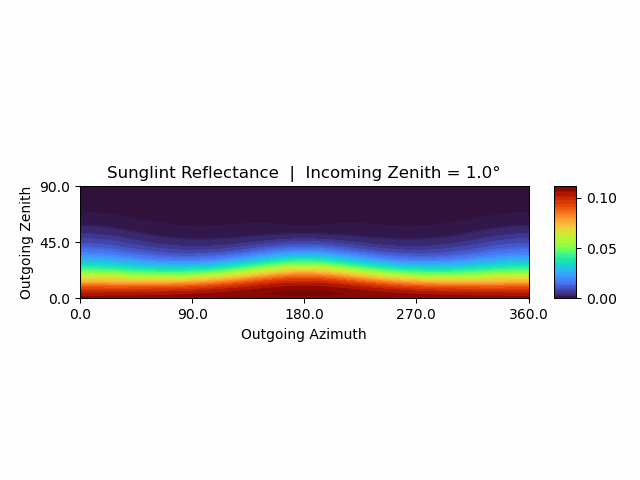

In [298]:
# display the animation
from IPython.display import Image

visual = visuals[5]
animation = Image(f'glints/{visual}.gif')
animation

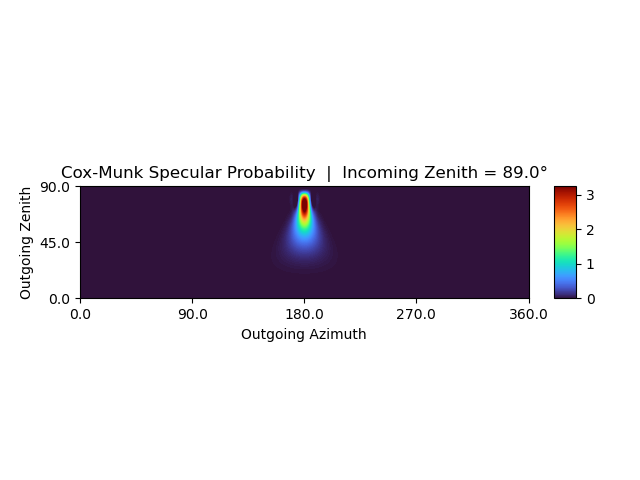

In [291]:
# View a certain frame of the animation
visual = visuals[0]
frame = 88
image = Image(f'glints/{visual}_{str(round(np.degrees(solar_zeniths[frame]), 2))}.png')
image

In [292]:
# 6S Comparison
azim_w = 0
wind_speed = 5

zenith_s = np.pi / 6
azim_s = 0

zenith_vs = np.linspace(np.deg2rad(1), np.deg2rad(89), 90)
azim_v = np.pi

n_real = 1.333
n_imag = 1.96e-09

results = {}
for zenith_v in zenith_vs:
    zenith_v = np.pi / 2 - zenith_v
    spec, R, tilt, cs, cv, reflectance = sunglint(zenith_v, zenith_s, azim_v, azim_s, azim_w, wind_speed, n_real, n_imag, chlorinity)
    if np.abs(np.pi / 2 - zen_s) < 1e-6:
        results[zenith_v] = {
            "specular": 0,
            "fresnel": 0,
            "tilt": 0,
            "cosine_solar": 0,
            "cosine_view": 0,
            "reflectance": 0
        }
        continue
    
    # Clamp the cosines to avoid numerical issues
    cs = np.clip(cs, 0, 1.0)
    cv = np.clip(cv, 0, 1.0)
    reflectance = (np.pi * R * spec) / (4.0 * cs * np.cos(tilt) ** 4)    
    results[zenith_v] = {
        "specular": spec,
        "fresnel": R,
        "tilt": tilt,
        "cosine_solar": cs,
        "cosine_view": cv,
        "reflectance": reflectance
    }

Text(0, 0.5, 'Sunglint Reflectance')

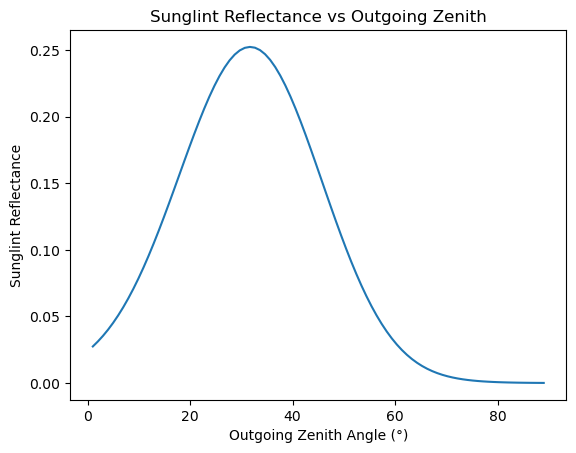

In [293]:
titles = {
    "specular": "Cox-Munk Specular Probability",
    "fresnel": "Fresnel Coefficient",
    "tilt": "Tilt Angle",
    "cosine_solar": "Cosine of Solar Angle",
    "cosine_view": "Cosine of View Angle",
    "reflectance": "Sunglint Reflectance"
}
variables = ["specular", "fresnel", "tilt", "cosine_solar", "cosine_view", "reflectance"]
index = 5
selected_variable = variables[index]
selected_title = titles[selected_variable]

# Plot the results by comparing the zenith angle of the sensor
# with the selected variable
values = []
for zenith_v, data in results.items():
    values.append(data[selected_variable])

plt.plot(np.degrees(zenith_vs), values)

# Add the title
plt.title(f'{selected_title} vs Outgoing Zenith')

# Add the labels
plt.xlabel('Outgoing Zenith Angle (°)')
plt.ylabel(f'{selected_title}')